# ABS Monthly Labour Force 6202

## Python set-up

In [1]:
# analytic imports
from matplotlib.patches import Patch
import pandas as pd
import readabs as ra
from readabs import metacol as mc

# local imports
from abs_helper import get_abs_data
from abs_summary_plot import plot_summary
from abs_plotting import (
    plot_rows_seas_trend,
    plot_rows_individually,
    plot_rows_collectively,
    iudts_from_row,
)
from plotting import (
    calc_and_plot_growth,
    plot_growth,
    plot_growth_finalise,
    line_plot,
    plot_covid_recovery,
    state_abbr,
    state_colors,
    finalise_plot,
)

# pandas display settings
pd.options.display.max_rows = 9999
pd.options.display.max_columns = 999

# display all charts in this notebook ...
SHOW = False

## Get data from ABS

In [2]:
abs_dict, meta, source, RECENT = get_abs_data("6202.0")
plot_times = None, RECENT
plot_tags = "", "-recent"

## Plot

### Labour force summary chart

In [3]:
def summarise() -> None:
    """Summarise the data in the ABS dataset"""

    required = {
        # order from least to most important (ie. bottom to top)
        # chart label: [ABS code, growth over n periods]
        "1 month growth: Civilian pop": ["A84423091W", 1],
        "12 month growth: Civilian pop": ["A84423091W", 12],
        "1 month growth: Num underemployed": ["A85255719L", 1],
        "12 months growth: Num underemployed": ["A85255719L", 12],
        "1 month growth: Num employed": ["A84423043C", 1],
        "12 months growth: Num employed": ["A84423043C", 12],
        "1 month growth: Num unemployed": ["A84423046K", 1],
        "12 months growth: Num unemployed": ["A84423046K", 12],
        "1 month growth: Num hours worked": ["A84426277X", 1],
        "12 month growth: Num hours worked": ["A84426277X", 12],
        "Underemployment ratio": ["A85255724F", 0],
        "Participation rate": ["A84423051C", 0],
        "Employment to pop ratio": ["A84423054K", 0],
        "Unemployment rate": ["A84423050A", 0],
    }

    plot_summary(
        required,
        abs_dict,
        meta,
        start="2000-01",
        title=f"Key labour force statistics {abs_dict['6202001'].index[-1]}",
        rfooter=source,
        lfooter="Australia. All seasonally adjusted except civilian population. "
        "All values are percentages",
        show=SHOW,
        verbose=False,
    )


summarise()

Overriding x0: True


### Sahm Rule

The Sahm Rule identifies signals related to the start of a recession when the three-month moving average of the national unemployment rate (U3) rises by 0.50 percentage points or more relative to its low during the previous 12 months.


In [4]:
def highlight(ax, series, color, alpha=0.5) -> None:
    """Add highlights to a chart based on a Boolean series."""

    shading, start, previous = False, None, None
    for index, item in series.items():
        if item and not shading:
            shading, start = True, index
        if shading and not item:
            ax.axvspan(start, previous, color=color, alpha=alpha)
            shading = False
        previous = index
    if shading:
        ax.axvspan(start, previous, color=color, alpha=alpha)

In [5]:
def hack_legend(ax, color, alpha, label) -> None:
    """Add a dummy entry to the legend to allow for a title."""

    patch = Patch(facecolor=color, alpha=alpha, label=label)
    handles, _labels = ax.get_legend_handles_labels()
    _lgd = ax.legend(handles=[handles[0], patch], loc="best", fontsize=8)

In [6]:
def sahm(sahm_threshhold=0.5) -> None:
    """Produce a chart that highlights periods where the unemployment rate
    has increased by more than a threshold."""

    range_color = "darkorange"
    range_alpha = 0.5

    uer_australia_sa = "A84423050A"
    m_uer = abs_dict["6202001"][uer_australia_sa]
    u3 = m_uer.rolling(3).mean()
    u3.name = "3 Month rolling average unemployment rate"
    ax = u3.plot(lw=2, c="blue")
    minimum = u3.rolling(12).min()
    print()
    sahm = minimum.shift(1) < u3 - sahm_threshhold  # shift for through the year

    highlight(ax, sahm, color=range_color, alpha=range_alpha)
    hack_legend(
        ax,
        range_color,
        range_alpha,
        f"Growth > {sahm_threshhold} percentage points over minimum through the year",
    )

    finalise_plot(
        ax,
        title=f"Unemployment Rate - with rate increases >{sahm_threshhold}pp thru' the year",
        ylabel="Per cent of Labour Force",
        y0=True,
        rfooter=source,
        lfooter=f"Australia. Seasonally adjusted. Monthly data. ",
        # contextual information ...
        rheader=f"Last 3 UER: {', '.join([str(x) for x in m_uer.iloc[-3:].round(2)])};  "
        + f"Last 3m MA: {', '.join([str(x) for x in u3.iloc[-3:].round(2)])};  "
        + f"Last 4m minimum: {', '.join([str(x) for x in minimum.iloc[-4:].round(2)])};  "
        + f"Headroom: {sahm_threshhold - (u3.iloc[-1] - minimum.iloc[-1]):.2f}",
        show=SHOW,
    )


def multi_sahm():
    for i in 0.5, 0.75:
        sahm(i)


multi_sahm()

### Headline seasonally adjusted/trend charts

In [7]:
def headline_charts():
    """Produce headline charts."""

    selector1 = {
        "6202001": mc.table,
        "Persons": mc.did,
    }

    selector2 = {
        "Monthly hours worked in all jobs ;  Persons ;": mc.did,
        "6202019": mc.table,
    }

    for selector in (selector1, selector2):
        plot_rows_seas_trend(
            abs_dict,
            meta,
            selector,
            starts=plot_times,
            tags=plot_tags,
            rfooter=source,
            lfooter="Australia. ",
            verbose=False,
            show=SHOW,
        )


headline_charts()

### Checking for data revisions - in headline 

In [8]:
def data_revisions(n: int = 6) -> None:
    """Plot data revisions."""

    dataset = [
        ("Unemployment rate ;  Persons ;", 1),
        ("Employment to population ratio ;  Persons ;", 1),
        ("Participation rate ;  Persons ;", 1),
        ("Employed total ;  Persons ;", 2),
        ("Unemployed total ;  Persons ;", 2),
        ("Labour force total ;  Persons ;", 2),
        ("Civilian population aged 15 years and over ;  Persons ;", 2),
    ]

    for series, rounds in dataset:
        for stype in "Original", "Trend":  # "Seasonally Adjusted",
            if "Civilian" in series and stype != "Original":
                continue
            if "Civilian" not in series and stype == "Original":
                continue
            repository = pd.DataFrame()
            history = None
            for i in range(n):
                d, m = ra.read_abs_cat(
                    "6202.0", single_excel_only="6202001", history=history
                )
                selector = {series: mc.did, stype: mc.stype}
                t, s, u = ra.find_abs_id(m, selector)
                date = f"ABS print for {d[t].index[-1].strftime("%b-%Y")}"
                repository[date] = d[t][s]
                history = (d[t].index[-1] - 1).strftime("%b-%Y").lower()

            abbrev = stype if stype != "Seasonally Adjusted" else "Seas Adj"
            prefix = ""
            for round in range(rounds):
                repository, u = ra.recalibrate(repository[repository.columns[::-1]], u)
                ax = repository.tail(15).plot(
                    lw=2,
                )

                # Annotate the last value in each series ...
                for c in repository.columns:
                    d = repository.loc[:, c].dropna()
                    x, y, s = (
                        d.index[-1],
                        d.iloc[-1],
                        f" {d.iloc[-1]:.{2 if d.iloc[-1] < 100 else 1}f}",
                    )
                    ax.text(x, y, s, fontsize=10, va="center", ha="left")

                title = f"{prefix}{series} ({abbrev.lower()})".replace(
                    "Persons ; ", ""
                ).replace(" ;", "").replace("  ", " ")
                finalise_plot(
                    ax,
                    title=title,
                    ylabel=u,
                    rfooter=source,
                    lfooter=f"Australia. {stype.capitalize()} series.",
                    legend={"loc": "best", "fontsize": 9},
                    tag="data-revisions",
                    y0=True,
                    show=SHOW,
                )
                prefix = "Monthly growth in "
                repository = repository.diff(1)


data_revisions()

### Headline COVID recovery charts

In [9]:
def covid_charts():
    """Produce pre/post COVID trajectory charts."""

    service_type = "Seasonally Adjusted"
    selector1 = {
        "Persons": mc.did,
        "6202001": mc.table,
        service_type: mc.stype,
    }
    selector2 = {
        "Monthly hours worked in all jobs ;  Persons ;": mc.did,
        "6202019": mc.table,
        service_type: mc.stype,
    }
    selector3 = {
        "Original": mc.stype,
        "6202001": mc.table,
        "Civilian population aged 15 years and over ;  Persons ;": mc.did,
    }

    for selector in (selector1, selector2, selector3):
        plot_rows_individually(
            abs_dict,
            meta,
            selector=selector,
            plot_function=plot_covid_recovery,
            tags="COVID",
            rfooter=source,
            lfooter=f"Australia. {service_type.capitalize()} series. ",
            show=SHOW,
        )


covid_charts()

### State comparisons 

In [10]:
# use linestyle to help differentiate datasets ...
linestyle = {
    "style": [
        "-.",
        "-",
        "--",
        ":",
    ]
    * 3  # repeat enough to cover all series
}

In [11]:
def state_charts():
    """Produced Unemployment and Rarticipation Rate charts for states."""

    states = (
        "New South Wales|Victoria|Queensland|South Australia"
        "|Western Australia|Tasmania|Northern Territory|Australian Capital Territory"
    )
    # service_type = "Seasonally Adjusted"
    service_type = "Trend"
    selector = {
        states: mc.did,
        service_type: mc.stype,
    }
    plot_stems = [
        "Unemployment rate ;  Persons",
        "Participation rate ;  Persons",
    ]

    for stem in plot_stems:
        xselector = selector | {stem: mc.did}
        plot_rows_collectively(
            abs_dict,
            meta,
            selector=xselector,
            regex=True,
            starts=["2000-01", RECENT],
            width=2,
            **linestyle,
            legend={"loc": "best"},
            rfooter=source,
            lfooter=f"Australia. {service_type.capitalize()} series.",
            show=SHOW,
        )

        # summary plot of Seasonally Adjusted UE rates by state
        stype = "Seasonally Adjusted"
        yselector = xselector.copy()
        yselector.pop("Trend")
        yselector[stype] = mc.stype
        rows = ra.search_abs_meta(meta, yselector, regex=True)
        names = rows[mc.did].str.split("> ").str[1].str.split(" ;").str[0].values
        ids = rows[mc.id].values
        to_get = {n: [i, 0] for n, i in zip(names[::-1], ids[::-1])}
        plot_summary(
            to_get,
            abs_dict,
            meta,
            start="2000-01",
            title=f"{stem.replace("; ", "-")} - for {abs_dict['6202012'].index[-1]}",
            lfooter=f"Australia. {stype.capitalize()} series.",
            rfooter=source,
            show=SHOW,
        )


state_charts()

Overriding x0: True
Overriding x0: True


In [12]:
def state_employment_growth():
    """Employed persions compared with the 2019 average / index = 100."""

    states = (
        "New South Wales|Victoria|Queensland|South Australia"
        "|Western Australia|Tasmania|Northern Territory|Australian Capital Territory"
    )
    selector = {
        states: mc.tdesc,
    }
    plot_stems = [
        ["Employed total ;  Persons ;", "Trend"],
        ["Unemployed total ;  Persons ;", "Trend"],
        ["Civilian population aged 15 years and over ;", "Original"],
    ]

    for stem, service_type in plot_stems:
        xselector = {
            **selector,
            stem: mc.did,
            service_type: mc.stype,
        }
        frame = pd.DataFrame()
        for _, row in ra.search_abs_meta(
            meta,
            xselector,
            exact=False,
            regex=True,
            verbose=False,
        ).iterrows():
            series_id, _, _, table, _ = iudts_from_row(row)
            state = row[mc.tdesc].split(" - ")[0]
            state = state.split(", ")[-1]
            frame[state] = abs_dict[table][series_id]
        if len(frame) == 0:
            continue

        for comparison_year in (2019, 2022):
            base = frame.loc[frame.index.year == comparison_year].mean()
            index_df = frame.divide(base) * 100
            index_df = index_df.loc[index_df.index.year >= comparison_year]
            index_df.columns = index_df.columns.map(state_abbr)

            title = f"{stem} cf {comparison_year} Ave.".replace(" ;", ";").replace(
                "  ", " "
            )
            line_plot(
                index_df,
                title=title,
                ylabel=f"Index ({comparison_year} = 100)",
                color=[state_colors[x] for x in index_df.columns],
                axhline={"y": 100, "lw": 0.75, "c": "#555555"},
                legend={"loc": "best", "fontsize": "x-small", "ncols": 2},
                **linestyle,
                rfooter=source,
                lfooter=f"Australia. {service_type.capitalize()} series.",
                width=2,
                show=SHOW,
            )


state_employment_growth()

### Headline Growth

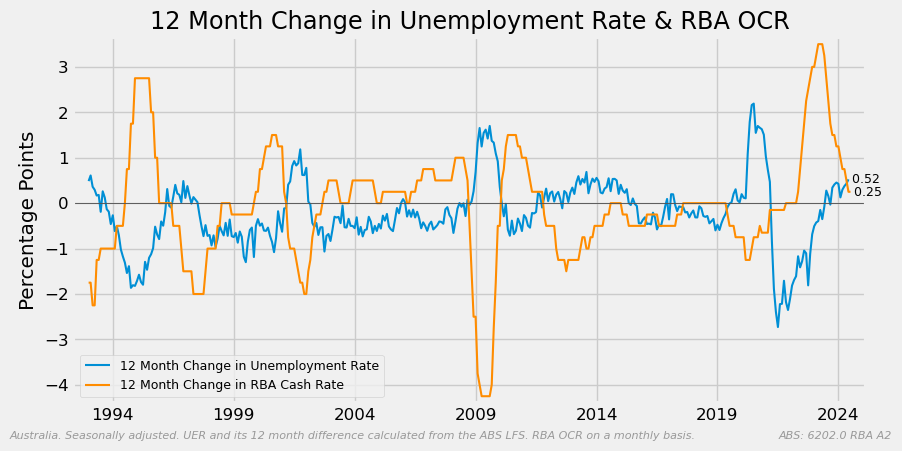

In [35]:
# 12 month change in uer
def uer_change():
    """Produce a chart showing the 12 month change in the unemployment rate."""

    employed, labour_force = abs_dict["6202001"]["A84423043C"], abs_dict["6202001"]["A84423047L"]
    uer = ((1 - employed / labour_force) * 100).dropna()
    #uermin = uer - uer.rolling(13).min()
    uer12 = uer.diff(12)["1993-01-01":]
    uer12.name = "12 Month Change in Unemployment Rate"

    rba12 = ra.read_rba_ocr().diff(12)["1993-01-01":]
    rba12.name = "12 Month Change in RBA Cash Rate"

    ax = uer12.plot(lw=1.5)
    ax.text(uer12.index[-1], uer12.iloc[-1], f" {uer12.iloc[-1]:.2f}", fontsize=9, va="center", ha="left")

    rba12.plot(ax=ax, lw=1.5, style="-", color="darkorange")
    ax.text(rba12.index[-1], rba12.iloc[-1], f" {rba12.iloc[-1]:.2f}", fontsize=9, va="center", ha="left")
    finalise_plot(
        ax,
        title="12 Month Change in Unemployment Rate & RBA OCR",
        ylabel="Percentage Points",
        y0=True,
        rfooter=f"{source} RBA A2",
        lfooter="Australia. Seasonally adjusted. UER and its 12 month difference "
        + "calculated from the ABS LFS. RBA OCR on a monthly basis.",
        legend={"loc": "best", "fontsize": 9},
        show=True,
    )


uer_change()

In [13]:
def employment_growth():
    """Employed persons growth."""

    for stype in "Trend", "Seasonally Adjusted", "Original":
        selector = {
            "6202001": mc.table,
            "Employed total ;  Persons ;": mc.did,
            stype: mc.stype,
        }
        table, sid, units = ra.find_abs_id(meta, selector, regex=True)
        print(stype, sid)
        employed = abs_dict[table][sid]
        growth = employed.diff(12), employed.diff(1)
        plot_growth_finalise(
            *growth,
            title=f"Employed persons - {stype} numeric growth",
            ylabel="Thousand Persons",
            from_=employed.index[-15],
            rfooter=source,
            lfooter=f"Australia. {stype} series. Monthly data.",
            annotate=10,
            annotation_rounding=0,
            y0=True,
            zero_y=True,
            show=SHOW,
        )


employment_growth()

Trend A84423127L
Seasonally Adjusted A84423043C
Original A84423085A


In [14]:
def growth_charts(plot_stems: str, service_type: str):
    """Produce % growth charts."""

    plot_rows_individually(
        abs_dict,
        meta,
        # data selection
        selector={
            "6202001": mc.table,
            plot_stems: mc.did,
            service_type: mc.stype,
        },
        regex=True,
        # plotting
        plot_function=calc_and_plot_growth,
        from_=list(plot_times)
        + [(pd.Timestamp.today() - pd.DateOffset(months=16)).strftime("%Y-%m-%d")],
        tag="growth",
        rfooter=source,
        annotate=10,
        lfooter=f"Australia. {service_type.capitalize()} series. ",
        y0=True,
        zero_y=True,
        show=SHOW,
    )


def chart_growth():
    """Structure/select growth charts for plotting."""

    # Seasonally adjusted series
    plot_stems = "|".join(
        [
            "Employed total ;  Persons ;",
            "Unemployed total ;  Persons ;",
            "Labour force total ;  Persons ;",
        ]
    )
    service_type = "Seasonally Adjusted"
    growth_charts(plot_stems, service_type)

    # Original series
    plot_stems = "|".join(
        [
            "Civilian population aged 15 years and over ;  Persons ;",
        ]
    )
    service_type = "Original"
    growth_charts(plot_stems, service_type)


chart_growth()

### Gendered comparisons

In [15]:
def gender_charts():
    """Produce gender comparison charts."""

    genders = ["Males", "Females"]
    colours = ["cornflowerblue", "hotpink"]

    token = "by gender"  # note: also appears in plot title
    plots = {
        # data description                       # table
        f"Employed total ;  > {token} ;": "6202001",
        f"> Employed part-time ;  > {token} ;": "6202001",
        f"> Employed full-time ;  > {token} ;": "6202001",
        f"Unemployed total ;  > {token} ;": "6202001",
        f"Labour force total ;  > {token} ;": "6202001",
        f"Unemployment rate ;  > {token} ;": "6202001",
        f"Participation rate ;  > {token} ;": "6202001",
        f"Monthly hours worked in all jobs ;  > {token} ;": "6202019",
    }

    series_type = "Seasonally Adjusted"

    for plot, table in plots.items():
        # assemble data
        collection = {}
        for gender in genders:
            this_gender = plot.replace(token, gender)

            search = {
                table: mc.table,
                series_type: mc.stype,
                this_gender: mc.did,
            }
            _, ident, units = ra.find_abs_id(meta, search)
            collection[gender] = abs_dict[table][ident]
        df = pd.DataFrame(collection)
        df, units = ra.recalibrate(df, units)

        title = f"Australia: {plot}".replace(" ;", "").replace("  ", " ")
        line_plot(
            df,
            starts=plot_times,
            tags=plot_tags,
            color=colours,
            title=title,
            ylabel=units,
            rfooter=f"{source} {table}",
            lfooter=f"{series_type.capitalize()} series",
            show=SHOW,
        )


gender_charts()

## Finished

In [16]:
# watermark
%load_ext watermark
%watermark -u -n -t -v -iv -w

Last updated: Thu Jul 18 2024 11:54:49

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.26.0

pandas : 2.2.2
readabs: 0.0.12

Watermark: 2.4.3



In [17]:
print("Finished")

Finished
